In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Redefine the file path below depending on where the dataset is saved
filepath = 'C:/Users/Hunter/Desktop/Measurabl Exercise/household_power_consumption/household_power_consumption.txt'

elec = pd.read_csv(filepath,sep=';',low_memory=False)

# Set the index as the date and time
elec['DateTime'] = elec["Date"] + " " + elec["Time"]
elec["DateTime"] = pd.to_datetime(elec["DateTime"], format="%d/%m/%Y %H:%M:%S")
elec=elec.drop(['Date','Time'],1)
elec.set_index('DateTime', inplace=True)

elec.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [2]:
# Replace missing value codes ('?') with NaN and make attributes numeric

elec['Global_active_power'] = elec['Global_active_power'].replace('?',np.NaN)
elec['Sub_metering_1'] = elec['Sub_metering_1'].replace('?',np.NaN)
elec['Sub_metering_2'] = elec['Sub_metering_2'].replace('?',np.NaN)

elec['Global_active_power'] = pd.to_numeric(elec['Global_active_power'])
elec['Sub_metering_1'] = pd.to_numeric(elec['Sub_metering_1'])
elec['Sub_metering_2'] = pd.to_numeric(elec['Sub_metering_2'])

elec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(4), object(3)
memory usage: 126.7+ MB


In [3]:
# Define all watt-hours of energy consumption not captured by sub meters
elec['Non_sub_metering'] = elec["Global_active_power"]*(1000)*(1/60) - elec['Sub_metering_1'] - elec["Sub_metering_2"] - elec['Sub_metering_3']

elec['Total_Wh'] = elec['Non_sub_metering'] + elec['Sub_metering_1'] + elec["Sub_metering_2"] + elec['Sub_metering_3']

# Create subset of energy consumption with common units (watt-hours)
wh = elec[['Non_sub_metering','Sub_metering_1','Sub_metering_2','Sub_metering_3','Total_Wh']]

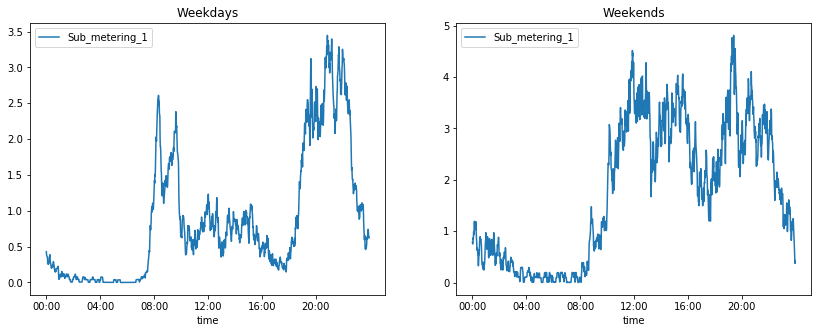

In [4]:
# Submeter 1 (kitchen): dishwasher, oven, microwave
# When is the kitchen used the most?
# When are the household's usual meal times during the week vs. weekend?

wh_kitchen = wh[['Sub_metering_1']]

wh_kitchen_weekend = np.where(wh_kitchen.index.weekday < 5, 'Weekday', 'Weekend')
wh_kitchen_by_time = wh_kitchen.groupby([wh_kitchen_weekend, wh_kitchen.index.time]).mean()

hourly_ticks = 4 * 60 * 60 * np.arange(6)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
wh_kitchen_by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style='-')
wh_kitchen_by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style='-');

# Weekdays, 8:00 - 9:00 AM: heat up breakfast and/or turn on the dishwasher before departing for work
# Weekdays, 7:00 - 8:00 PM and later: meals and/or dishwashing upon returning home from work
#
# Weekends, more gradual spike later in the morning: sleeping in with a later breakfast?
# Weekends 12:00 PM and afternoon hours: occasionally home for lunch/snacks/earlier dinner?

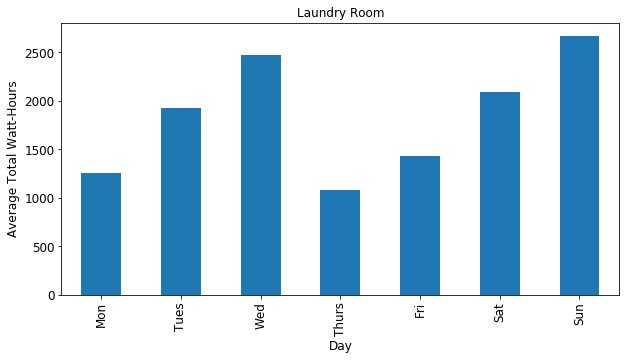

In [5]:
# Submeter 2 (laundry): washing machine, drier, refrigerator, light
# Refrigerator should be constant, and light should be intermittent
# Periods with highest consumption should correspond to washing machine and/or drier operating along with light & refrig.
# So what days were laundry days? Any routine schedule?

wh_laundry = wh[['Sub_metering_2']]

wh_laundry_daily = wh_laundry.resample('D').sum()
wh_laundry_by_weekday = wh_laundry_daily.groupby(wh_laundry_daily.index.dayofweek).mean()
wh_laundry_by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

plot = wh_laundry_by_weekday.plot(kind='bar', title ="Laundry Room",figsize=(10,5),legend=False, fontsize=12)
plot.set_xlabel("Day",fontsize=12)
plot.set_ylabel("Average Total Watt-Hours",fontsize=12);

# Sunday (end of week) and Wednesday (mid-week) appear to be the most popular laundry days,
# With the next consecutive days, Monday and Thursday, showing the two lowest averages.
# This makes sense because there is rarely a need to do laundry two days in a row.

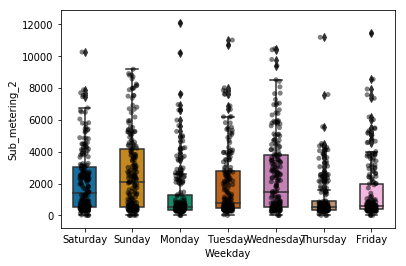

In [8]:
# Submeter 2 (laundry), continued
# Just how decisive is the distinction of being a favorite laundry day?

wh_laundry_daily['Weekday'] = wh_laundry_daily.index.day_name()

bplot = sns.boxplot(y='Sub_metering_2', x='Weekday', 
                 data=wh_laundry_daily, 
                 width=0.5,
                 palette="colorblind")

bplot = sns.stripplot(y='Sub_metering_2', x='Weekday', 
                   data=wh_laundry_daily, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

# While Sunday and Wednesday see higher energy usage in the laundry room on average,
# other days also show plenty of instances of high usage.
# Life can be unpredictable and it's not always easy to keep up the routine.

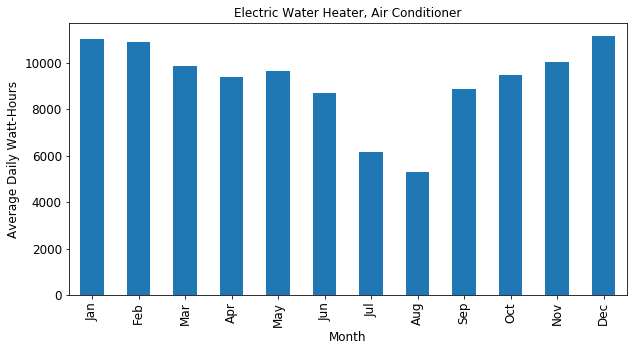

In [9]:
# Submeter 3: electric water heater, air conditioner
# Which months are more mild and which ones impact comfort more significantly (increasing the need for AC)?

wh_hvac = wh[['Sub_metering_3']]

wh_hvac_daily = wh_hvac.resample('D').sum()
wh_hvac_by_month = wh_hvac_daily.groupby(wh_hvac_daily.index.month).mean()
wh_hvac_by_month.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plot = wh_hvac_by_month.plot(kind='bar', title='Electric Water Heater, Air Conditioner', figsize=(10,5),legend=False, fontsize=12)
plot.set_xlabel("Month",fontsize=12)
plot.set_ylabel("Average Daily Watt-Hours",fontsize=12);

# July and August appear to be the most mild based on the average daily load for this submeter;
# December, January, and February are likely to generally have the most extreme temperatures,
# increasing the demand for energy usage applicable to this submeter.
#
# A quick check on Wikipedia (https://en.wikipedia.org/wiki/Paris#Climate) confirms
# that those three months tend to have the coldest days on average.
# The increased energy usage is likely driven by higher demand for heating.

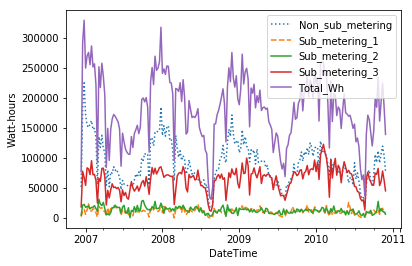

In [10]:
# Which of the sub meters is most relevant for seeking possible efficiency gains?

# General overview visualization - weekly watt-hour totals
weekly_wh = wh.resample('W').sum()
weekly_wh.plot(style=[':', '--', '-'])
plt.ylabel('Watt-hours');

# Sub meter 3 makes up the largest share of total usage among the sub meters.
# If the residents are looking to increase efficiency, a smart thermostat or another form of
# AC load management can be considered.

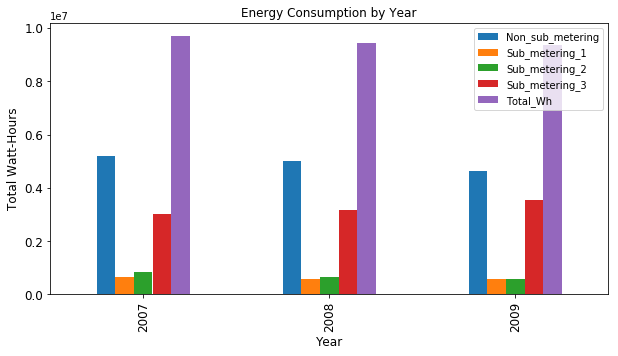

In [11]:
# Above, it appears that usage during overall peak periods from 2007 and beyond may be decreasing.
# Has energy consumption overall been decreasing over the years (possible efficiency gains)?

# Calculate yearly totals of energy consumption
yearly_wh = wh.resample('Y').sum()
yearly_wh.index = ['2006', '2007', '2008', '2009', '2010']

# View in bar plot (drop 2006 and 2010 for now because they're only partially represented)
year_plot = yearly_wh.iloc[1:4].plot(kind='bar', title ="Energy Consumption by Year",figsize=(10,5),legend=True, fontsize=12)
year_plot.set_xlabel("Year",fontsize=12)
year_plot.set_ylabel("Total Watt-Hours",fontsize=12);

# No visibly significant decline.

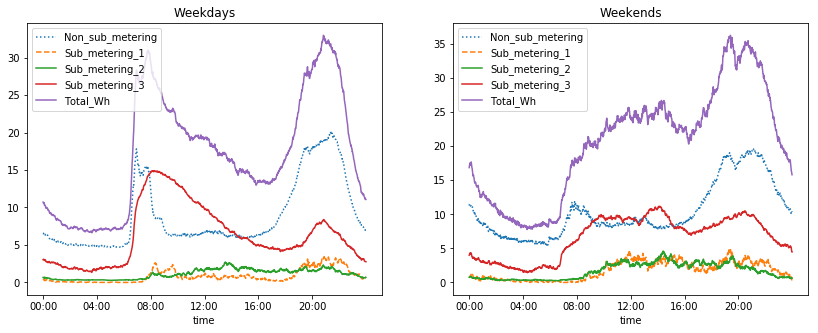

In [12]:
# Do the energy usage patterns indicate a set of routine times associated with the work week?

wh_weekend = np.where(wh.index.weekday < 5, 'Weekday', 'Weekend')
wh_by_time = wh.groupby([wh_weekend, wh.index.time]).mean()

hourly_ticks = 4 * 60 * 60 * np.arange(6)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
wh_by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
wh_by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

# Note that weekdays show a bimodal energy consumption pattern.
# There indeed appears to be room for efficiency gains between the departure for work
# and the arrival back home from work. The electric water heater and/or air conditioner
# appear to be driving the slow pace of decline after the start of work hours.
# this represents a likely opportunity to improve efficiency.